# _Set Up_

In [24]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os
from pathlib import Path

# Matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [26]:
path = os.getcwd()
path

'/Users/joeai/Springboard/unit17-take-home-challenges/ultimate_technologies'

# _Load in Data_

In [32]:
file = path + '/logins.json'
file

'/Users/joeai/Springboard/unit17-take-home-challenges/ultimate_technologies/logins.json'

In [33]:
logins_df = pd.read_json(file)

In [34]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [35]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [36]:
print(logins_df.min())
print(logins_df.max())

login_time   1970-01-01 20:12:16
dtype: datetime64[ns]
login_time   1970-04-13 18:57:38
dtype: datetime64[ns]


# _Extract Date Info from `login-df`_

In [37]:
logins_df['month'] = logins_df['login_time'].dt.month
logins_df['day'] = logins_df['login_time'].dt.day
logins_df['hour'] = logins_df['login_time'].dt.hour
logins_df['minute'] = logins_df['login_time'].dt.minute
logins_df.head()

,login_time,month,day,hour,minute
0,1970-01-01 20:13:18,1,1,20,13
1,1970-01-01 20:16:10,1,1,20,16
2,1970-01-01 20:16:37,1,1,20,16
3,1970-01-01 20:16:36,1,1,20,16
4,1970-01-01 20:26:21,1,1,20,26


In [10]:
list(logins_df.columns[1:4])

['month', 'day', 'hour']

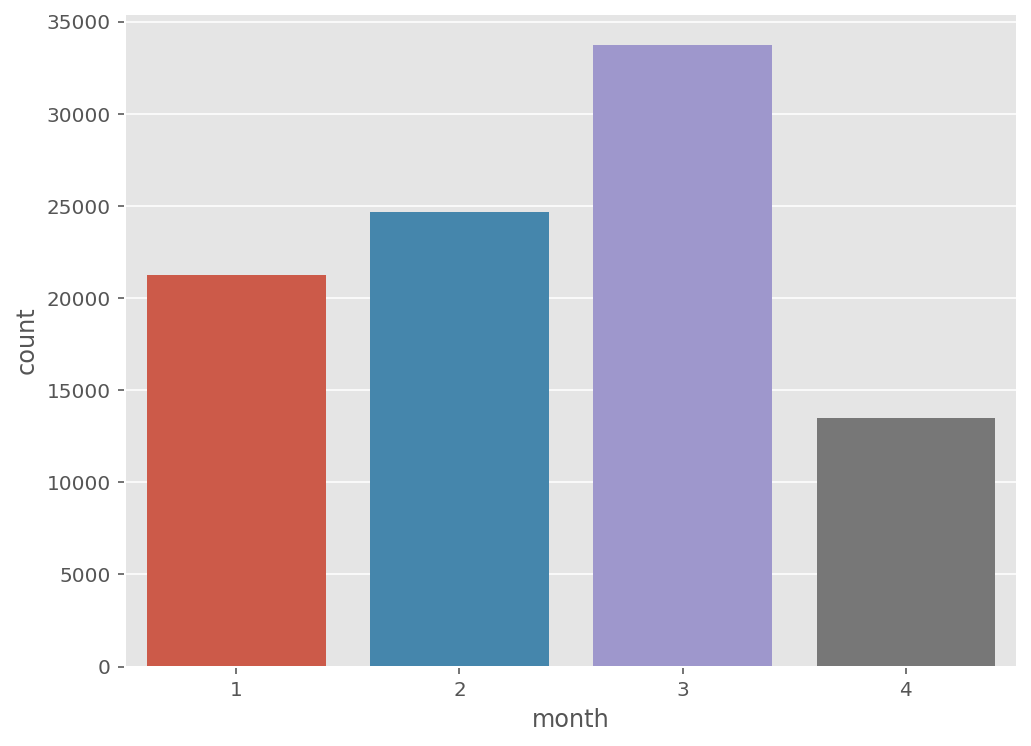

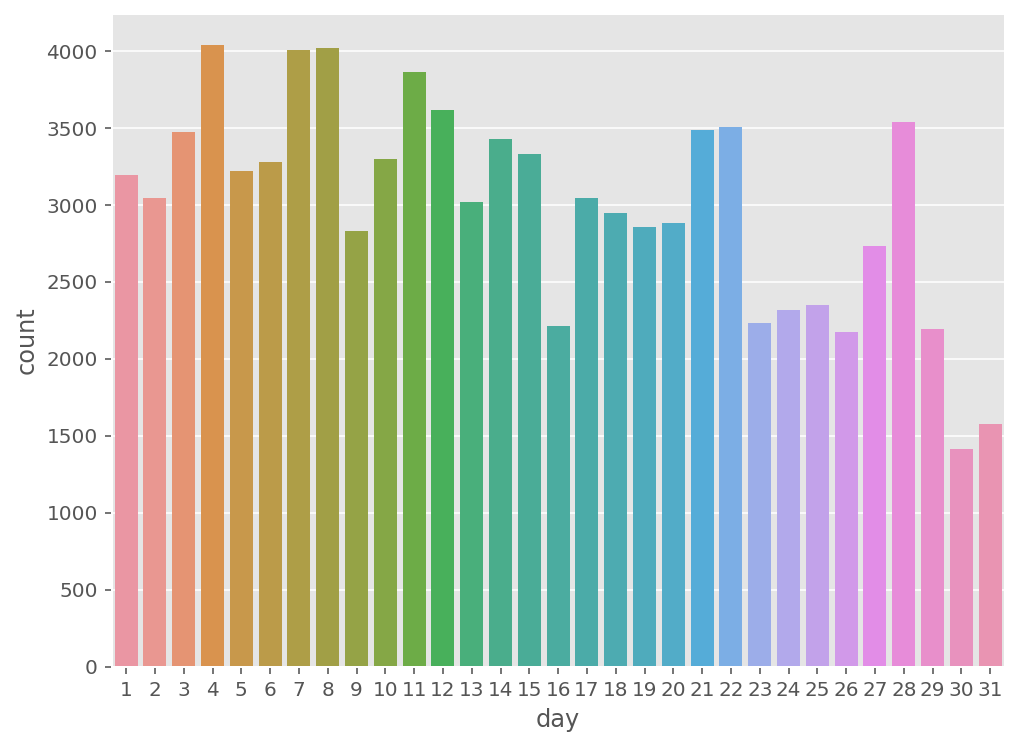

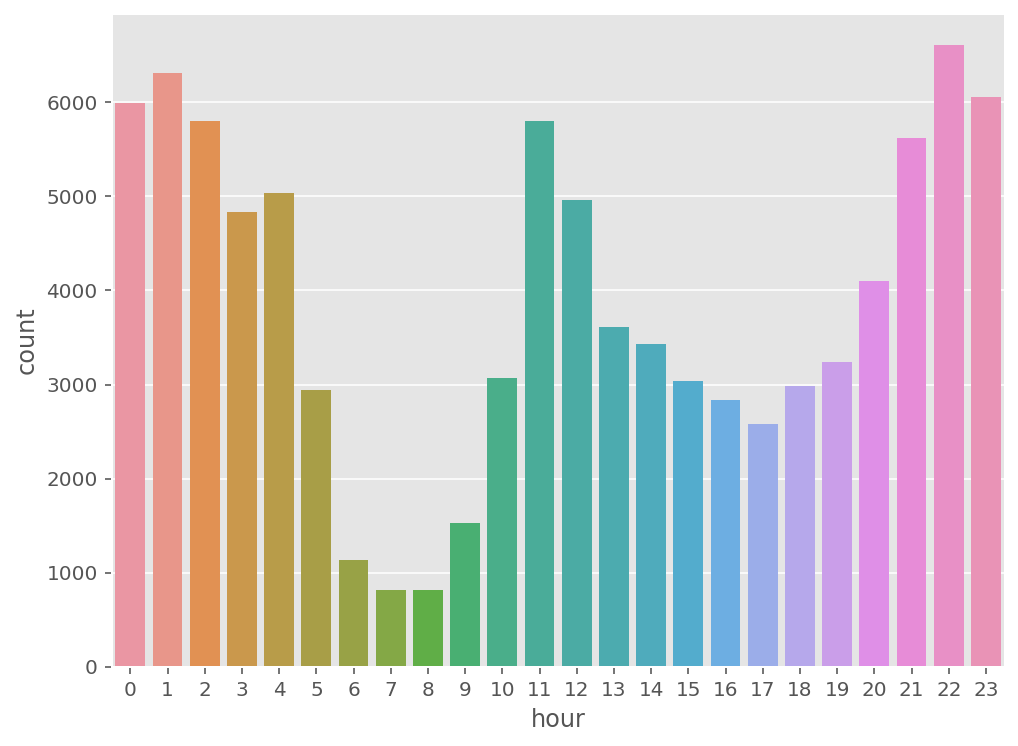

In [11]:
for col in list(logins_df.columns[1:4]):
    plt.figure(figsize=(8,6))
    sns.countplot(x=col, data=logins_df)

# _Observations_

The graphs above give us a great high-level overview of the breakdown by month, day and hour. Here are some quick insights we can gather from the graphs above:

- Number of logins steadily increased until the third month, and then dropped off rather suddenly in the fourth month (which is probably the result of observations only going to `4/13`)
- There looks to be more logins towards the beginning of the month than towards the end
- Logins by hour look to peak around noon and midnight 

Now let's resample the observations into 15-minute intervals to try and gain further insights.

# _Resample: 15 min Intervals_

In [12]:
# create new df from logins_df
interval_df = logins_df.set_index('login_time')
# to represent a login
interval_df['count'] = 1
# can drop the other observations for the interval_df
interval_df.drop(['month', 'day', 'hour', 'minute'], axis=1, inplace=True)
# resample with 15 min intervals
interval_df = interval_df.resample('15T').sum()

interval_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


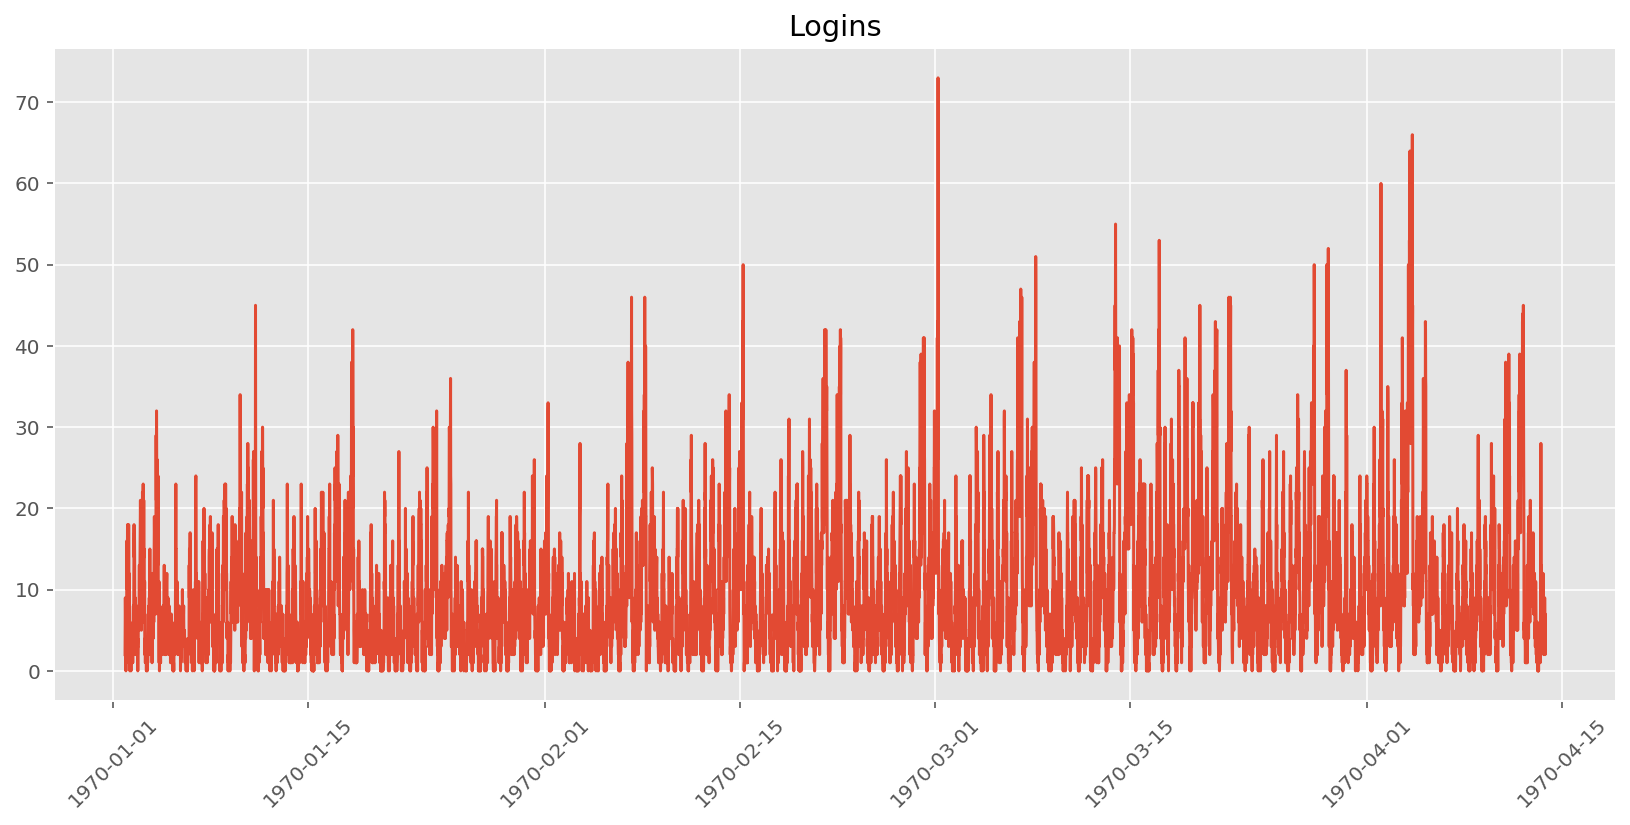

In [16]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(14,6))
plt.plot(interval_df)
plt.xticks(rotation=45)
plt.title('Logins');

# _Observations_

That didn't go as planned. While this graph provides little value, we can still see that there appear to be peak times in regards to logins, so it's not completely useless!

# _Separate Data into Months_

In [17]:
jan_df = interval_df['1970-01-01':'1970-01-31'].reset_index(drop=False)
feb_df = interval_df['1970-02-01':'1970-02-28'].reset_index(drop=False)
march_df = interval_df['1970-03-01':'1970-03-31'].reset_index(drop=False)
apr_df = interval_df['1970-04-01':'1970-04-13'].reset_index(drop=False)

In [18]:
jan_df.tail()

,login_time,count
2891,1970-01-31 22:45:00,16
2892,1970-01-31 23:00:00,10
2893,1970-01-31 23:15:00,9
2894,1970-01-31 23:30:00,7
2895,1970-01-31 23:45:00,14


In [19]:
feb_df.tail()

,login_time,count
2683,1970-02-28 22:45:00,20
2684,1970-02-28 23:00:00,23
2685,1970-02-28 23:15:00,27
2686,1970-02-28 23:30:00,17
2687,1970-02-28 23:45:00,18


In [20]:
march_df.tail()

,login_time,count
2971,1970-03-31 22:45:00,21
2972,1970-03-31 23:00:00,24
2973,1970-03-31 23:15:00,23
2974,1970-03-31 23:30:00,23
2975,1970-03-31 23:45:00,14


In [21]:
apr_df.tail()

,login_time,count
1223,1970-04-13 17:45:00,5
1224,1970-04-13 18:00:00,5
1225,1970-04-13 18:15:00,2
1226,1970-04-13 18:30:00,7
1227,1970-04-13 18:45:00,6


# _January Analysis_

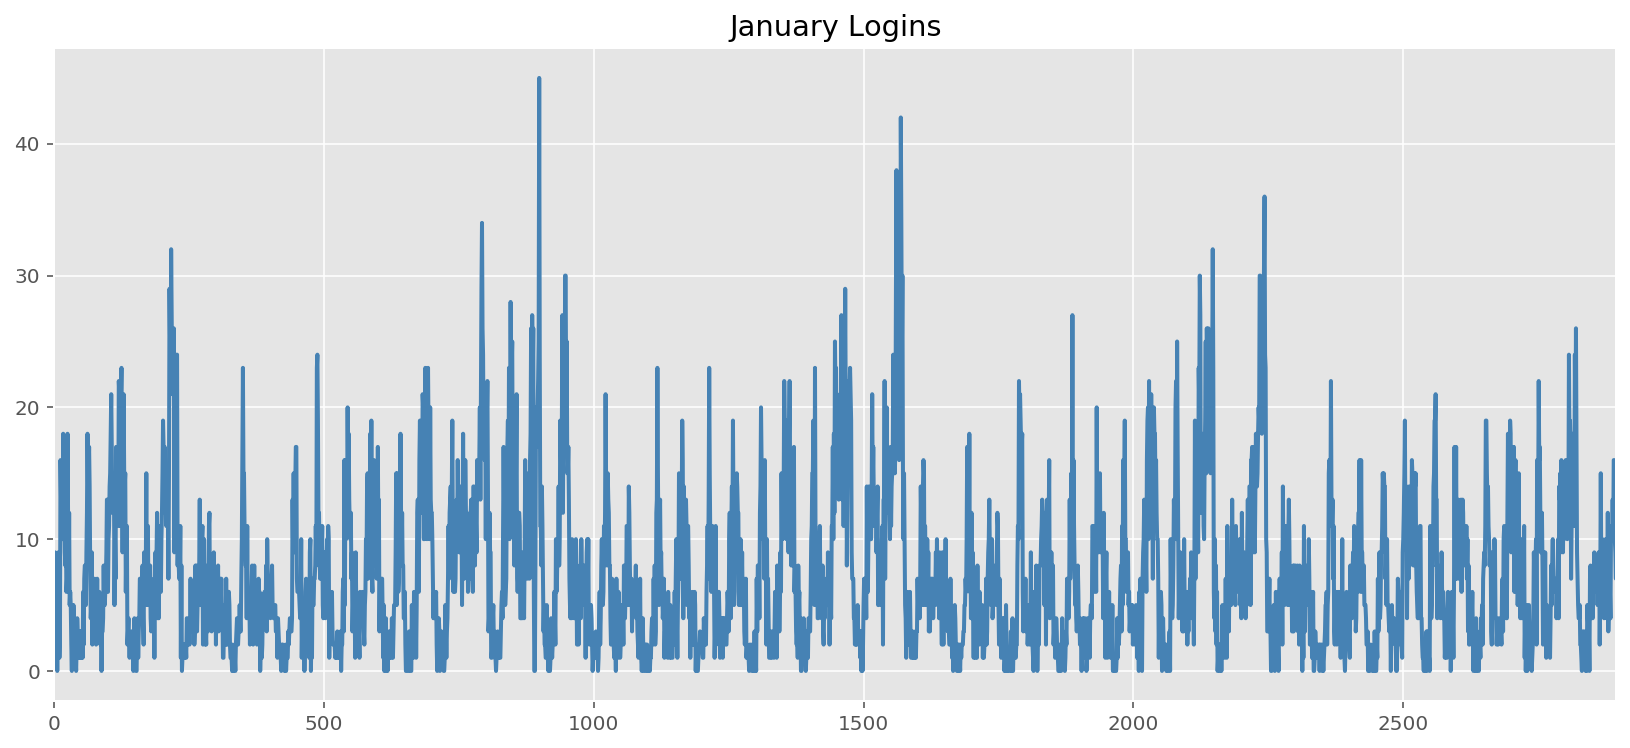

In [23]:
jan_df['count'].plot(figsize=(14,6), linewidth=2, legend=False, title='January Logins', color='steelblue');

# _Observations_

So this is a little more informative than our original plot from above. First, we get to see the trend in number of logins over just the month of January; second, we can pick up that there appear to be four spikes in the number of logins. 

I have a hunch that these spikes might be on (or near) weekends. So next we'll try to breakdown the analysis into days of the week.

We can do this by using `datetime`'s `isoweekday()`, which returns the day of the week as an integer, where Monday is 1 and Sunday is 7.

In [91]:
jan_df['login_time'].map(lambda x: x.isoweekday())[10:20]

10    4
11    4
12    4
13    4
14    4
15    4
16    5
17    5
18    5
19    5
Name: login_time, dtype: int64

As we can see above, the numbers start at `4` and then transition to `5`, signifying a Thursday (i.e. `4`) becoming Friday (i.e. `5`).

Let's add a column titled `day_of_week` to assign observations to their respective day of the week.

In [92]:
jan_df['day_of_week'] = jan_df['login_time'].map(lambda x: x.isoweekday())
jan_df.head()

,login_time,count,day_of_week
0,1970-01-01 20:00:00,2,4
1,1970-01-01 20:15:00,6,4
2,1970-01-01 20:30:00,9,4
3,1970-01-01 20:45:00,7,4
4,1970-01-01 21:00:00,1,4


In [104]:
jan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2896 entries, 0 to 2895
Data columns (total 3 columns):
login_time     2896 non-null datetime64[ns]
count          2896 non-null int64
day_of_week    2896 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 68.0 KB


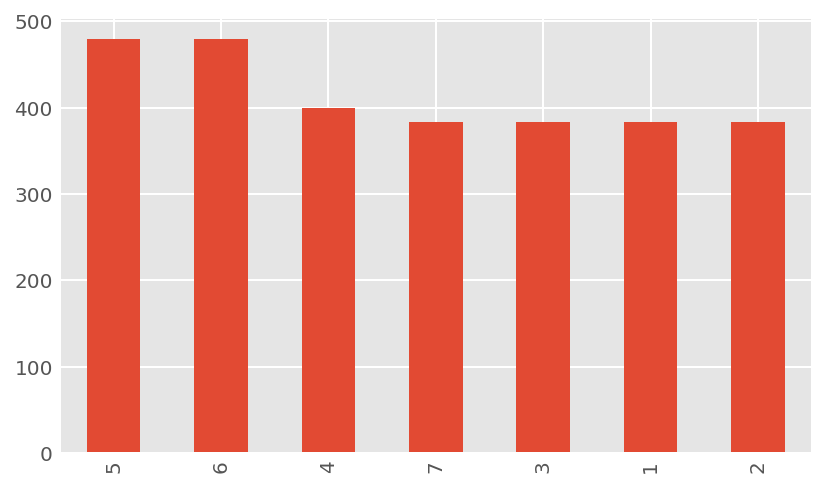

In [110]:
jan_df['day_of_week'].value_counts().plot(kind='bar')

In [97]:
sorted(jan_df['day_of_week'].unique())

[1, 2, 3, 4, 5, 6, 7]

In [101]:
trial = jan_df[['login_time', 'count']].set_index('login_time')

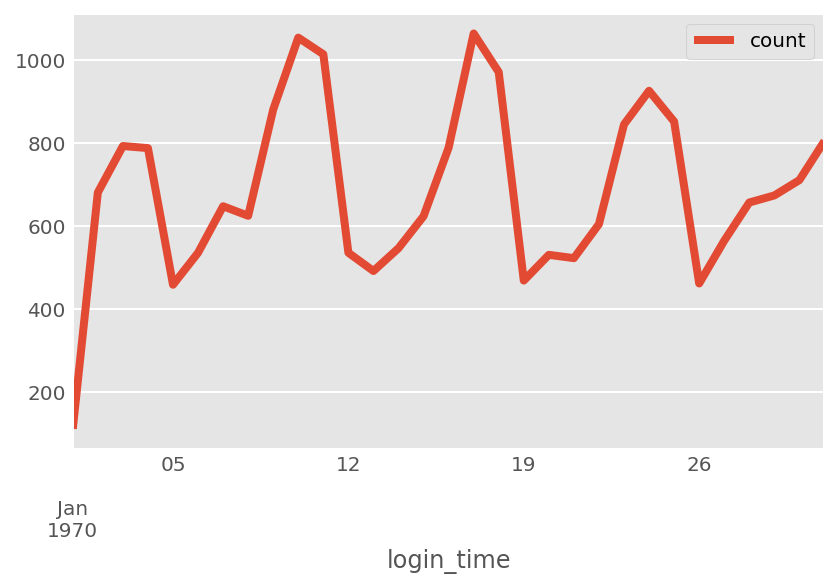

In [103]:
trial.resample('d').sum().plot();

In [ ]:
grouped_df = df_copy.groupby(pd.Grouper(key='login_time', freq='15M'))

In [ ]:
grouped_df.head()

In [ ]:
grouped_df.groups